# Running DASK for Week 8

Wonje Yun, Adam Wu

## 1. Running DASK on AWS EC2

To run DASK on AWS EC2, we need to install dask cloud provider to launch the EC2 instance, and controll it locally.
To install dask cloud provider, we need to install the package in either way:

```bash
# Using pip
$ pip install dask-cloudprovider[aws]

# If pip does not work, use conda
$ conda install -c conda-forge dask-cloudprovider
```

After installing the package, make sure to update the credentials, since we are still using AWS EC2.

In [1]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

In [2]:
# We need this function to get the AWS credentials from the config file to pass to the EC2Cluster

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

In [3]:
# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs" # we are going to install s3fs library on the cluster

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0] # find the python version
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}" # get the dask docker tag that matches the client version
print('Docker Image: ', dask_docker_tag)

Docker Image:  daskdev/dask:2022.02.1-py3.10


In [5]:
# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Creating scheduler instance


KeyboardInterrupt: 

In [ ]:
client = Client(cluster)
client # note that slight mismatches between client, scheduler, and worker software are fine

In [ ]:
import dask.dataframe as dd

df = dd.read_parquet('s3://nyc-tlc/trip data/yellow_tripdata_2015*.parquet',
                     engine='pyarrow').persist()

In [ ]:
df.describe() \
  .compute()

In [6]:
cluster.close()

NameError: name 'cluster' is not defined

## 2. Running DASK on Local Machine

You can install dask on your local machine using pip.

```bash
$ pip install dask
```

Also, to visualize the dask graph, you can install graphviz.

```bash
$ pip install graphviz
```

### 2-1. Graphviz Installation

If graphviz cannot be installed, look [here](https://stackoverflow.com/questions/73830695/failed-to-execute-posixpathdot-make-sure-the-graphviz-executables-are-on-y) for help.

#### 2-1-1. For macOS, follow the steps:

1. Install grpahviz using brew:
```bash
brew install graphviz
```

2. To test if graphviz is installed, run the following command:
```bash
$ dot -V
```

#### 2-1-2. For Windows:

1. Download the graphviz installer from [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html).

2. Install the downloaded file.

3. Add the path to the environment variable:
```bash
C:\Program Files\Graphviz\bin
```

4. To test if graphviz is installed, run the following command:
```bash
$ dot -V
```

Or look [here](https://stackoverflow.com/questions/45092771/how-to-install-graphviz-2-38-on-windows-10) for more information.


In [12]:
import dask
from dask.distributed import Client

In [13]:
client = Client()
client # note that slight mismatches between client, scheduler, and worker software are fine

/Users/yun-wonje/anaconda3/envs/macs30123/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62884 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:62884/status,
Dashboard: http://127.0.0.1:62884/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62886,Workers: 4
Dashboard: http://127.0.0.1:62884/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:62897,Total threads: 2
Dashboard: http://127.0.0.1:62900/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:62892,


In [18]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = range(4)

output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

In [19]:
total.compute()

22

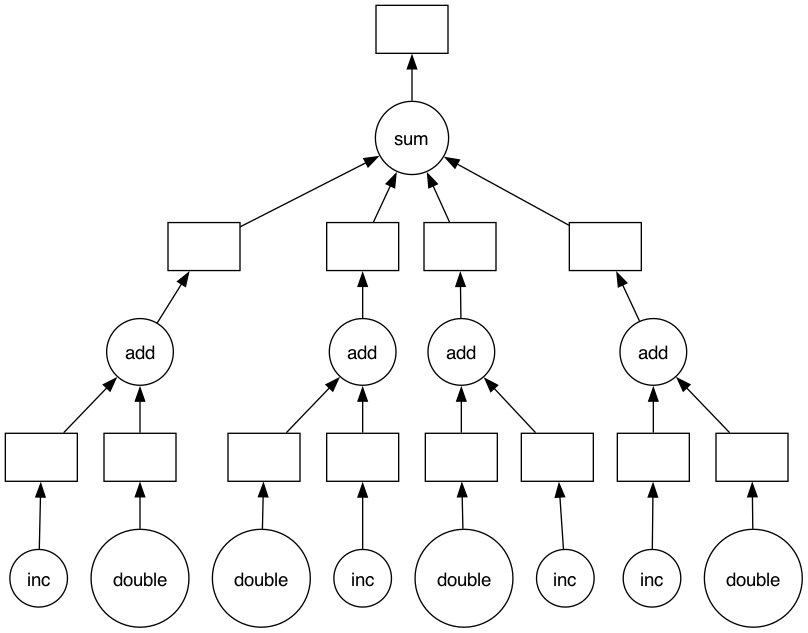

In [23]:
total.visualize() # can use format='svg' if the graph is too large

## 3. Running DASK on Midway Cluster

For launching jupuyter lab on Midway, refer to [Midway Jupyter Guide](https://rcc-uchicago.github.io/user-guide/software/apps-and-envs/python/?h=jupyter#running-jupyterlab)

1. login to Midway3 using ssh
2. Load the python module and install required packages ti request Midway cluster for Dask cluster
```bash
$ module load python
$ pip install --user dask[complete]==2022.7.0 dask-jobqueue==0.7.4 dask-ml==2022.5.27
```
3. Determine the IP address
```bash
$ HOST_IP=`/sbin/ip route get 8.8.8.8 | awk '{print $7;exit}'`
$ echo $HOST_IP
```
4. Launch Jupyter Lab
```bash
$ jupyter lab --no-browser --ip=$HOST_IP --port=15021 # the port number can be any number
```
5. Cpoy the URL and paste it in your local browser
6. To shutdown the Jupyter Lab, press `Ctrl + C` in the terminal (for both windows and mac)

From the Jupyter Lab, you can access the files in your Midway account and run the DASK ipython code provided in `in-class-activities/08_Dask/8M_Intro/dask_ml_midway.ipynb`